In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with correct separator
file_path = "/home/maria/CrimeStats/data/avalik_1(1).csv"
dat = pd.read_csv(file_path, sep='\t', encoding='utf-8')

# Filter for Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

# Parse date and time
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

# Combine to datetime
tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])

# Clean and split crime types
tallinn['SyndmusLiik'] = (
    tallinn['SyndmusLiik']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Split by comma and explode to new rows
tallinn_expanded = tallinn.assign(
    SyndmusLiik=tallinn['SyndmusLiik'].str.split(',')
).explode('SyndmusLiik')

# Remove whitespace and invalid empty entries
tallinn_expanded['SyndmusLiik'] = tallinn_expanded['SyndmusLiik'].str.strip()
tallinn_expanded = tallinn_expanded[tallinn_expanded['SyndmusLiik'] != '']

# Set datetime index
tallinn_expanded.set_index('ToimDatetime', inplace=True)

# Group by day and crime type
daily_crime_matrix = (
    tallinn_expanded
    .groupby([pd.Grouper(freq='D'), 'SyndmusLiik'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
daily_crime_matrix.shape
daily_crime_matrix

SyndmusLiik,AVALIKU_KORRA_RIKKUMINE,ILLEGAALNE_KAUBA_MUUK,JALGRATTA_MOPEEDI_VARGUS,JUHTUM_LOOMAGA,JUHTUM_TULIRELVAGA,KADUNUD_ESE/DOKUMENT,KAUPLEMISE_NOUETE_RIKKUMINE,KEHALINE_VAARKOHTLEMINE,KELMUS,KONFLIKT/OMAVOLI,...,MUU,NARKOJUHTUM,PISIVARGUS,PLAHVATUS,POMMIAHVARDUS_KAHTLUS,ROOVIMINE,TULEKAHJU,VALIMISED,VANDALISM,VARGUS
ToimDatetime,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,4,8
2024-01-02,1,0,0,0,0,0,0,1,0,0,...,0,0,6,0,0,0,0,0,0,6
2024-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,5
2024-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,4
2024-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-15,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
2025-05-16,0,0,0,0,0,0,0,0,0,0,...,1,0,3,0,0,0,0,0,0,3
2025-05-18,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1


In [3]:
daily_crime_matrix.columns

Index(['AVALIKU_KORRA_RIKKUMINE', 'ILLEGAALNE_KAUBA_MUUK',
       'JALGRATTA_MOPEEDI_VARGUS', 'JUHTUM_LOOMAGA', 'JUHTUM_TULIRELVAGA',
       'KADUNUD_ESE/DOKUMENT', 'KAUPLEMISE_NOUETE_RIKKUMINE',
       'KEHALINE_VAARKOHTLEMINE', 'KELMUS', 'KONFLIKT/OMAVOLI',
       'LEITUD_LOHKEKEHA(-AINE)', 'LIIKLUSONNETUS', 'LIIKLUSRIKKUMINE',
       'LITTER', 'METALLIVARGUS', 'MOOTORSOIDUKI_VARGUS', 'MUU', 'NARKOJUHTUM',
       'PISIVARGUS', 'PLAHVATUS', 'POMMIAHVARDUS_KAHTLUS', 'ROOVIMINE',
       'TULEKAHJU', 'VALIMISED', 'VANDALISM', 'VARGUS'],
      dtype='object', name='SyndmusLiik')

In [2]:
total_daily_crime=daily_crime_matrix.sum(axis=1)

In [3]:
import numpy as np
np.save('crime_ts.npy', total_daily_crime)

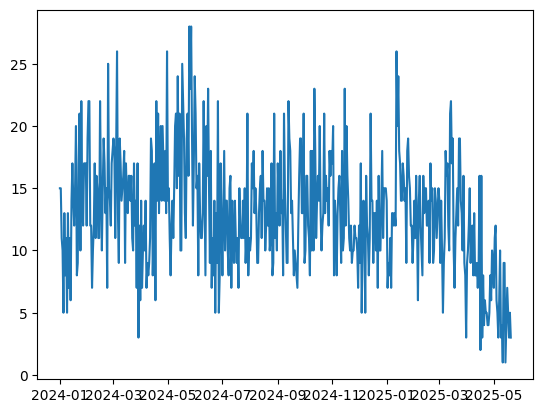

In [6]:
plt.plot(total_daily_crime)

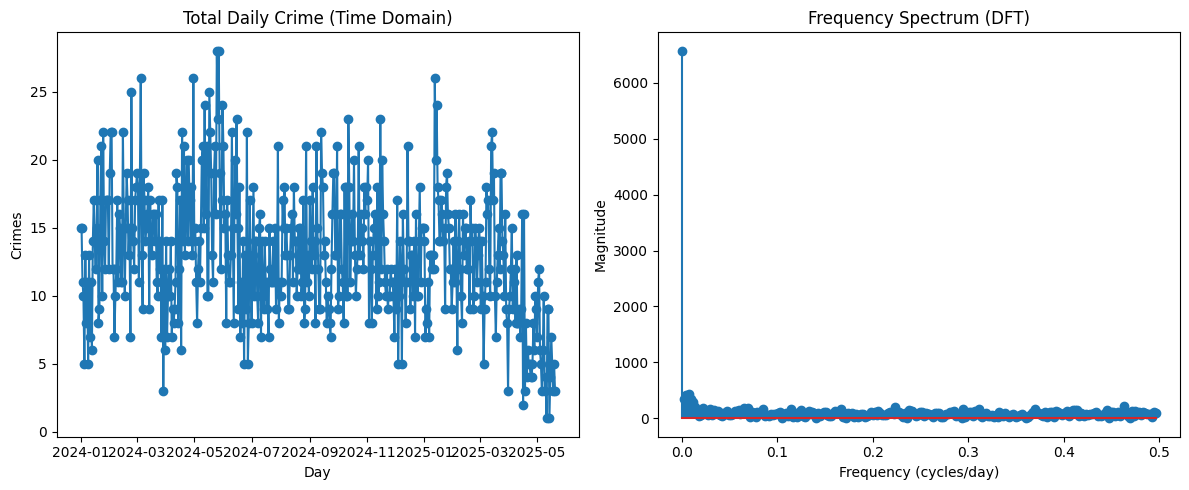

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have daily_crime_matrix as a NumPy array
total_daily_crime = daily_crime_matrix.sum(axis=1)

# --- DFT using numpy.fft ---
N = len(total_daily_crime)
dft = np.fft.fft(total_daily_crime)
freqs = np.fft.fftfreq(N, d=1)

# --- Magnitude spectrum ---
magnitude = np.abs(dft)

# --- Plot time series ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(total_daily_crime, marker="o")
plt.title("Total Daily Crime (Time Domain)")
plt.xlabel("Day")
plt.ylabel("Crimes")

# --- Plot frequency spectrum ---
plt.subplot(1,2,2)
plt.stem(freqs[:N//2], magnitude[:N//2])  # removed use_line_collection
plt.title("Frequency Spectrum (DFT)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


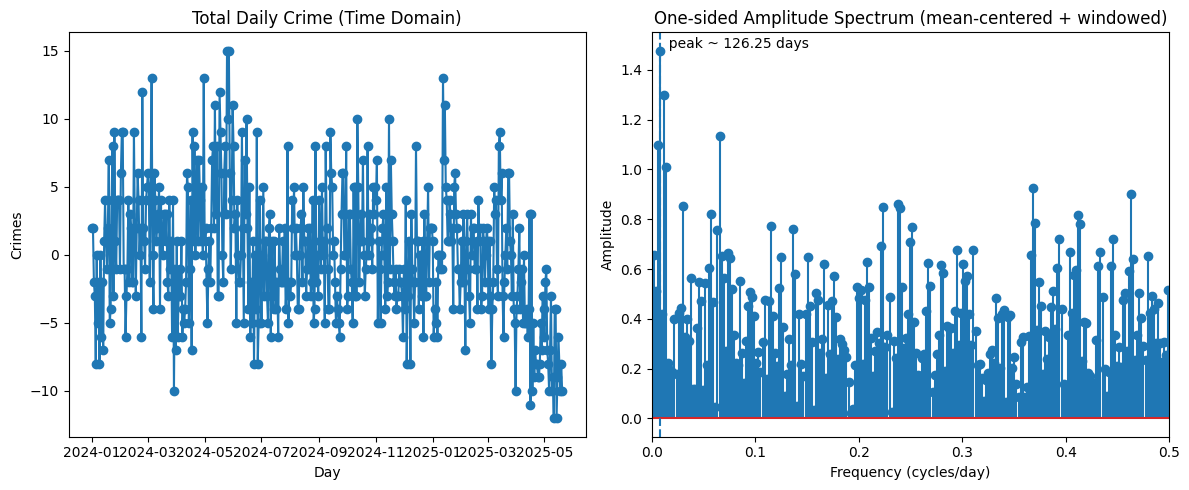

Dominant non-DC frequency ≈ 0.00792 cycles/day (period ≈ 126.25 days)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
# Optional: from scipy.signal import detrend  # uncomment if you want linear detrending

# --- your signal ---
x = daily_crime_matrix.sum(axis=1).astype(float)
N = len(x)
fs = 1.0   # samples/day (daily data)

# --- remove DC (and optional slow linear trend) ---
x = x - x.mean()
# x = detrend(x, type="linear")  # optional, needs SciPy

# --- window to reduce spectral leakage ---
w = np.hanning(N)
xw = x * w

# --- FFT (one-sided) ---
X = np.fft.rfft(xw)                      # length N//2+1 complex spectrum
f = np.fft.rfftfreq(N, d=1/fs)           # cycles/day

# --- amplitude scaling ---
# Window coherent gain (amplitude correction) ~ mean of window
cg = w.mean()
# One-sided amplitude spectrum: scale by 2/N for bins 1..end-1; DC/N and Nyquist/N stay single-sided
A = np.abs(X) / (N * cg)
if N % 2 == 0:
    # even N -> Nyquist bin exists at the end
    A[1:-1] *= 2.0
else:
    A[1:] *= 2.0

# --- find dominant non-DC peak ---
if len(A) > 2:
    idx_peak = np.argmax(A[1:]) + 1   # skip DC (bin 0)
    f_peak = f[idx_peak]
    period_days = (1.0 / f_peak) if f_peak > 0 else np.inf
else:
    f_peak, period_days = 0.0, np.inf

# --- plots ---
plt.figure(figsize=(12,5))

# time domain
plt.subplot(1,2,1)
plt.plot(x + x.mean(), marker="o")  # plot around original mean for intuition
plt.title("Total Daily Crime (Time Domain)")
plt.xlabel("Day")
plt.ylabel("Crimes")

# frequency domain (amplitude)
plt.subplot(1,2,2)
plt.stem(f, A)
plt.xlim(0, 0.5)  # up to Nyquist (0.5 cycles/day)
plt.title("One-sided Amplitude Spectrum (mean-centered + windowed)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")

# annotate dominant peak (if meaningful)
if np.isfinite(period_days) and f_peak > 0:
    plt.axvline(f_peak, linestyle="--")
    plt.text(f_peak, A[idx_peak], f"  peak ~ {period_days:.2f} days", va="bottom")

plt.tight_layout()
plt.show()

print(f"Dominant non-DC frequency ≈ {f_peak:.5f} cycles/day (period ≈ {period_days:.2f} days)")


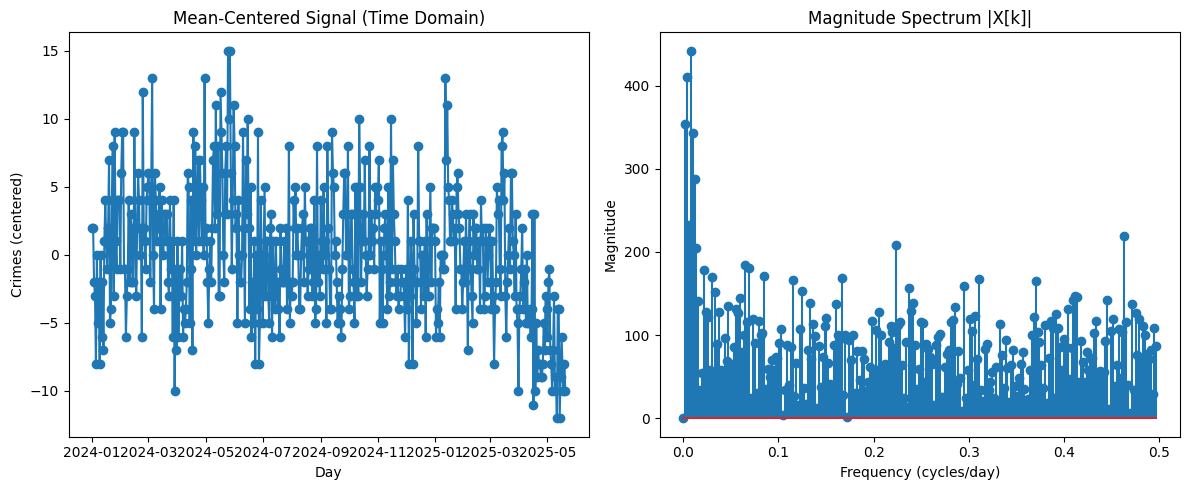

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- signal ---
x = daily_crime_matrix.sum(axis=1).astype(float)
N = len(x)

# --- mean-center ---
x = x - x.mean()

# --- DFT ---
X = np.fft.fft(x)
freqs = np.fft.fftfreq(N, d=1)  # cycles/day since data is daily

# --- plot ---
plt.figure(figsize=(12,5))

# time domain
plt.subplot(1,2,1)
plt.plot(x, marker="o")
plt.title("Mean-Centered Signal (Time Domain)")
plt.xlabel("Day")
plt.ylabel("Crimes (centered)")

# frequency domain (only first half: positive freqs)
plt.subplot(1,2,2)
plt.stem(freqs[:N//2], np.abs(X[:N//2]))
plt.title("Magnitude Spectrum |X[k]|")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()
